In [2]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
import time
import numpy as np


In [3]:

starttime = time.time()
#reading in GEDI points
gedi_df = gpd.read_file('GEDI_data/clipped_gedi.gpkg', driver='GPKG', index = True)
endtime = time.time()
print(f"Reading in the GEDI shapefile took {endtime - starttime} seconds")
# print(gedi_df.head())
#reading in ICESat2 shapefile
icesat_df = gpd.read_file('GEDI_data/clipped_icesat.shp', driver='ESRI Shapefile', index = True)
# print(icesat_df.head())


Reading in the GEDI shapefile took 2577.54851436615 seconds


In [22]:
# Get unique values in GeoTIFF column
unique_geotiffs = icesat_df['GeoTIFF'].unique()

# Specify the file location of the TIFF files
tif_folder = 'reprojected_icesat_to_gedi_crs'

gedi_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
min = np.full((len(gedi_bins)+1), np.inf)
max = np.zeros(len(gedi_bins)+1)
num_points = np.zeros(len(gedi_bins)+1)
mean_helper = np.zeros(len(gedi_bins)+1)
std_helper = np.zeros(len(gedi_bins)+1)

# Iterate over unique GeoTIFF values
for geotiff in unique_geotiffs:
    # Create an empty list to store the data
    list = []
    
    # print(geotiff)
    # Construct the file path
    tif_file = os.path.join(tif_folder, geotiff[:-4] + '_reprojected.tif')
    
    # Load the TIFF file using rasterio
    with rasterio.open(tif_file) as icesat_tif:
        print(icesat_tif)

        filtered_df =  gpd.read_file('GEDI_data/clipped_gedi.gpkg', driver='GPKG', index = True, bbox=icesat_tif.bounds)
        print(filtered_df.head())
        # Iterate through the "gedi shot number" values
        for _, point in filtered_df.iterrows():
            # point = point[1]
            # Extract the GEDI shot number
            gedi_shot_number = point['shot_numbe']

            # print(point)
            # print("GEDI shot number:", gedi_shot_number)

            # Extract the latitude, longitude, and agbd values
            lat = point['lat_lowest']
            lon = point['lon_lowest']
            agbd_gedi = point['agbd']

            # # Print the extracted values
            # print("Latitude:", lat)
            # print("Longitude:", lon)

            row, col = icesat_tif.index(lon, lat)
            agbd_icesat = icesat_tif.read(1)[row, col]

            # print("AGBD icesat:", agbd_icesat)
            # print("AGBD gedi:", agbd_gedi)
            # print("Difference:", agbd_icesat - agbd_gedi)
            # print()
            if agbd_icesat != -9999:
                index = np.digitize(agbd_gedi, gedi_bins)
                difference = agbd_gedi - agbd_icesat
                num_points[index] += 1
                if difference < min[index]:
                    min[index] = difference
                if difference > max[index]:
                    max[index] = difference
                mean_helper[index] += difference
                std_helper[index] += difference**2
                

                # Create a dictionary with the data
                data = {
                    'Gedi Shot Number': gedi_shot_number,
                    'ICESat Tile': geotiff,
                    'ICESat AGBD': agbd_icesat,
                    'GEDI AGBD': agbd_gedi,
                    'Difference': agbd_gedi - agbd_icesat,
                    'Latitude': lat,
                    'Longitude': lon
                }

                # Append the data to the list
                list.append(data)
    #save the dataframe to a csv file
    df = pd.DataFrame(list) 
    df.to_csv(f'gedi_icesat_agbd_comparison_{geotiff}.csv', index=False)
    print("Dataframe saved to csv file")
     



<open DatasetReader name='reprojected_icesat_to_gedi_crs/boreal_agb_202302061675678869_4191_reprojected.tif' mode='r'>
   pft_class  region_cla  leaf_off_f  urban_prop      agbd   agbd_se  beam  \
0          6           2           0           0  1.484886  3.004534     8   
1          6           2           0           0  1.484886  3.004534    11   
2          6           2           0           0  1.257357  3.005806     6   
3          6           2           0           0  1.422379  3.004870     6   
4          6           2           0           0  1.484886  3.004534     6   

   elev_lowes  lat_lowest  lon_lowest  selected_a         shot_numbe  \
0   142.82283   51.917021  135.927406           1  98800800300291173   
1   141.09047   51.911206  135.930489           1  98801100300289983   
2   140.13779   51.909918  135.928855           1  99410600300397489   
3   140.57982   51.909973  135.928032           1  99410600300397488   
4   140.86572   51.910028  135.927209           1  9

In [3]:
gedi_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
min = np.full((len(gedi_bins)+1), np.inf)
max = np.zeros(len(gedi_bins)+1)
num_points = np.zeros(len(gedi_bins)+1)
mean_helper = np.zeros(len(gedi_bins)+1)
std_helper = np.zeros(len(gedi_bins)+1)

# print("num_points " + str(num_points))
# print("min " + str(min))
# print("max " + str(max))
# print("mean_helper " + str(mean_helper))
# print("std_helper " + str(std_helper))

folder = 'comparisons_bins'
i = 0
# Iterate over unique GeoTIFF values
for file in os.listdir(folder):
    # Create an empty list to store the data
    # list = []
    # i+=1
    # if i == 4:
    #     break


    filtered_df =  pd.read_csv(os.path.join(folder, file))
    # Iterate through the "gedi shot number" values
    for _, point in filtered_df.iterrows():

        # print(point)
        i += 1
        # point = point[1]
        # Extract the GEDI shot number
        gedi_shot_number = point['Gedi Shot Number']
        lat = point['Latitude']
        lon = point['Longitude']
        agbd_gedi = point['GEDI AGBD']
        agbd_icesat = point['ICESat AGBD']

        # if (np.isnan(agbd_gedi) or np.isnan(agbd_icesat)):
        #     print(point)

        if (0 <= agbd_icesat <= 500 and 0 <= agbd_gedi <= 500 and not np.isnan(agbd_gedi) and not np.isnan(agbd_icesat)):
            index = np.digitize(agbd_gedi, gedi_bins)
            difference = agbd_gedi - agbd_icesat
            num_points[index] += 1
            if difference < min[index]:
                min[index] = difference
            if difference > max[index]:
                max[index] = difference
            mean_helper[index] += difference
            std_helper[index] += difference**2
    # print("=====================================")
    print(file)
    # print("num_points " + str(num_points))
    # print("min " + str(min))
    # print("max " + str(max))
    # print("mean_helper " + str(mean_helper))
    # print("std_helper " + str(std_helper))

print("done")


     



gedi_icesat_agbd_comparison_boreal_agb_202302061675662992_3787.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675664614_4323.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675664841_4431.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675665322_4358.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675665893_3594.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666045_3500.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666457_3691.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666514_3410.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666627_3501.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666888_3877.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666898_3595.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666959_3779.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675667165_3960.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675667209_3688.tif.csv
gedi_i

In [3]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
icesat_histograms = np.zeros((len(bins)+1, len(bins)+1))
gedi_histograms = np.zeros((len(bins)+1, 10))
min = np.full((len(bins)+1), np.inf)
max = np.zeros(len(bins)+1)
num_points = np.zeros(len(bins)+1)
mean_helper = np.zeros(len(bins)+1)
std_helper = np.zeros(len(bins)+1)

# print("num_points " + str(num_points))
# print("min " + str(min))
# print("max " + str(max))
# print("mean_helper " + str(mean_helper))
# print("std_helper " + str(std_helper))

folder = 'comparisons_bins'
i = 0
# Iterate over unique GeoTIFF values
for file in os.listdir(folder):
    # Create an empty list to store the data
    # list = []
    # i+=1
    # if i == 4:
    #     break


    filtered_df =  pd.read_csv(os.path.join(folder, file))
    # Iterate through the "gedi shot number" values
    for _, point in filtered_df.iterrows():

        # print(point)
        i += 1
        # point = point[1]
        # Extract the GEDI shot number
        gedi_shot_number = point['Gedi Shot Number']
        lat = point['Latitude']
        lon = point['Longitude']
        agbd_gedi = point['GEDI AGBD']
        agbd_icesat = point['ICESat AGBD']

        # if (np.isnan(agbd_gedi) or np.isnan(agbd_icesat)):
        #     print(point)

        if (0 <= agbd_icesat <= 500 and 0 <= agbd_gedi <= 500 and not np.isnan(agbd_gedi) and not np.isnan(agbd_icesat)):
            index = np.digitize(agbd_gedi, bins)
            if int((agbd_gedi-bins[index-1])/2.5)>9:
                gedi_histograms[index][9] += 1
            else:
                gedi_histograms[index][int((agbd_gedi-bins[index-1])/2.5)] += 1

            icesat_index = np.digitize(agbd_icesat, bins)
            icesat_histograms[index][icesat_index] += 1

            difference = agbd_gedi - agbd_icesat
            num_points[index] += 1
            if difference < min[index]:
                min[index] = difference
            if difference > max[index]:
                max[index] = difference
            mean_helper[index] += difference
            std_helper[index] += difference**2
    # print("=====================================")
    print(file)
    # print(icesat_histograms.astype(int))
    # print(gedi_histograms)
    # print("num_points " + str(num_points))
    # print("min " + str(min))
    # print("max " + str(max))
    # print("mean_helper " + str(mean_helper))
    # print("std_helper " + str(std_helper))

print("done")


     



gedi_icesat_agbd_comparison_boreal_agb_202302061675662992_3787.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675664614_4323.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675664841_4431.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675665322_4358.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675665893_3594.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666045_3500.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666457_3691.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666514_3410.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666627_3501.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666888_3877.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666898_3595.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666959_3779.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675667165_3960.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675667209_3688.tif.csv
gedi_i

In [4]:
mean = mean_helper/num_points
std = np.sqrt(std_helper/num_points - mean**2)
mean = mean[1:]
std = std[1:]
min = min[1:]
max = max[1:]

/tmp/ipykernel_1516651/687996800.py:1: RuntimeWarning: invalid value encountered in divide
  mean = mean_helper/num_points
/tmp/ipykernel_1516651/687996800.py:2: RuntimeWarning: invalid value encountered in divide
  std = np.sqrt(std_helper/num_points - mean**2)


num_points [      0. 2201914. 1421192. 1239657. 1142874. 1053323.  965635.  815600.
  630651.  453975.  303311.  193508.  120109.  216265.]
min [-233.46785  -217.390065 -234.34376  -163.12546  -142.74236  -119.20233
 -109.62164   -97.87068  -142.19773   -71.51545     6.24846     6.99348
   25.99223 ]
max [ 21.395808   45.7538118  70.5180294  95.2045097 120.30104   144.4784895
 169.8515642 194.9483527 220.149851  245.3831356 268.684046  294.648539
 490.897158 ]
mean [-15.43015818 -15.83155586  -1.21497494  16.57825203  36.96185687
  58.35688423  79.64186536 101.1151213  123.43307742 146.45509873
 170.02912929 194.494426   269.78457203]
std [20.19450104 26.86014496 26.6388969  26.22350265 26.32540273 26.8712116
 27.63053245 28.08870623 28.40446928 28.75482296 29.35309643 29.99236542
 65.03652252]


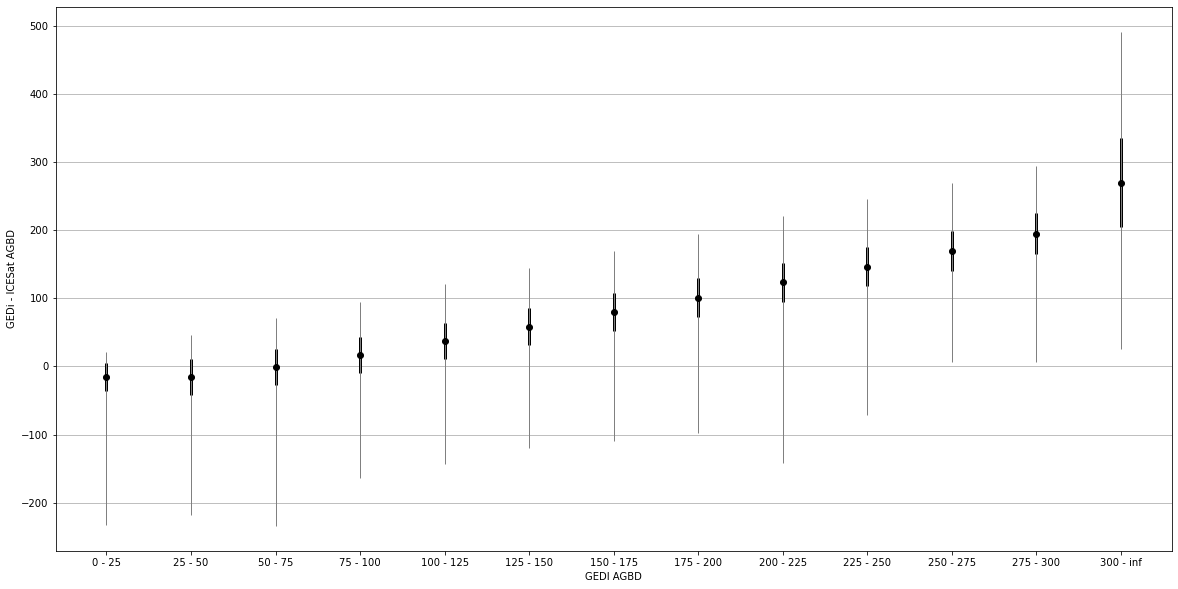

In [5]:
import matplotlib.pyplot as plt

print("num_points " + str(num_points))
print("min " + str(min))
print("max " + str(max))
print("mean " + str(mean))
print("std " + str(std))

# Calculate quartiles
q1 = mean - std
q3 = mean + std

gedi_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]

# Create boxplot
plt.figure(figsize = (20,10))
# plt.boxplot(mean)
# create stacked errorbars:
plt.errorbar(gedi_bins, mean, std, fmt='ok', lw=3)
plt.errorbar(gedi_bins, mean, [mean - min, max - mean],
             fmt='.k', ecolor='gray', lw=1)
xticks = ["" for i in range(len(gedi_bins))]
for i in range(len(gedi_bins)-1):
    xticks[i] = (str(gedi_bins[i]) + " - "+ str(gedi_bins[i+1]) )
xticks[-1] = ("300 - inf" )
plt.xticks(gedi_bins, labels=xticks)
plt.xlabel('GEDI AGBD')
plt.ylabel('GEDi - ICESat AGBD')y
plt.grid(axis='y')
plt.show()



[[      0       0       0       0       0       0       0       0       0
        0       0       0       0       0]
 [      0 1222150  673157  202641   75282   23563    4384     596     125
       12       3       1       0       0]
 [      0  218907  504520  412184  202996   65908   14151    2187     296
       37       5       1       0       0]
 [      0   77508  320451  453045  276865   91043   17615    2709     365
       45      10       0       0       1]
 [      0   36291  204327  429795  326990  118249   23356    3267     520
       67      10       2       0       0]
 [      0   21971  140011  379438  339164  137847   29853    4251     668
      105      14       1       0       0]
 [      0   15237  108110  322236  321423  155555   36916    5266     758
      118      15       1       0       0]
 [      0   10498   78851  243525  274895  159149   41320    6172    1016
      149      22       3       0       0]
 [      0    6980   51742  165774  215514  144095   39293    607

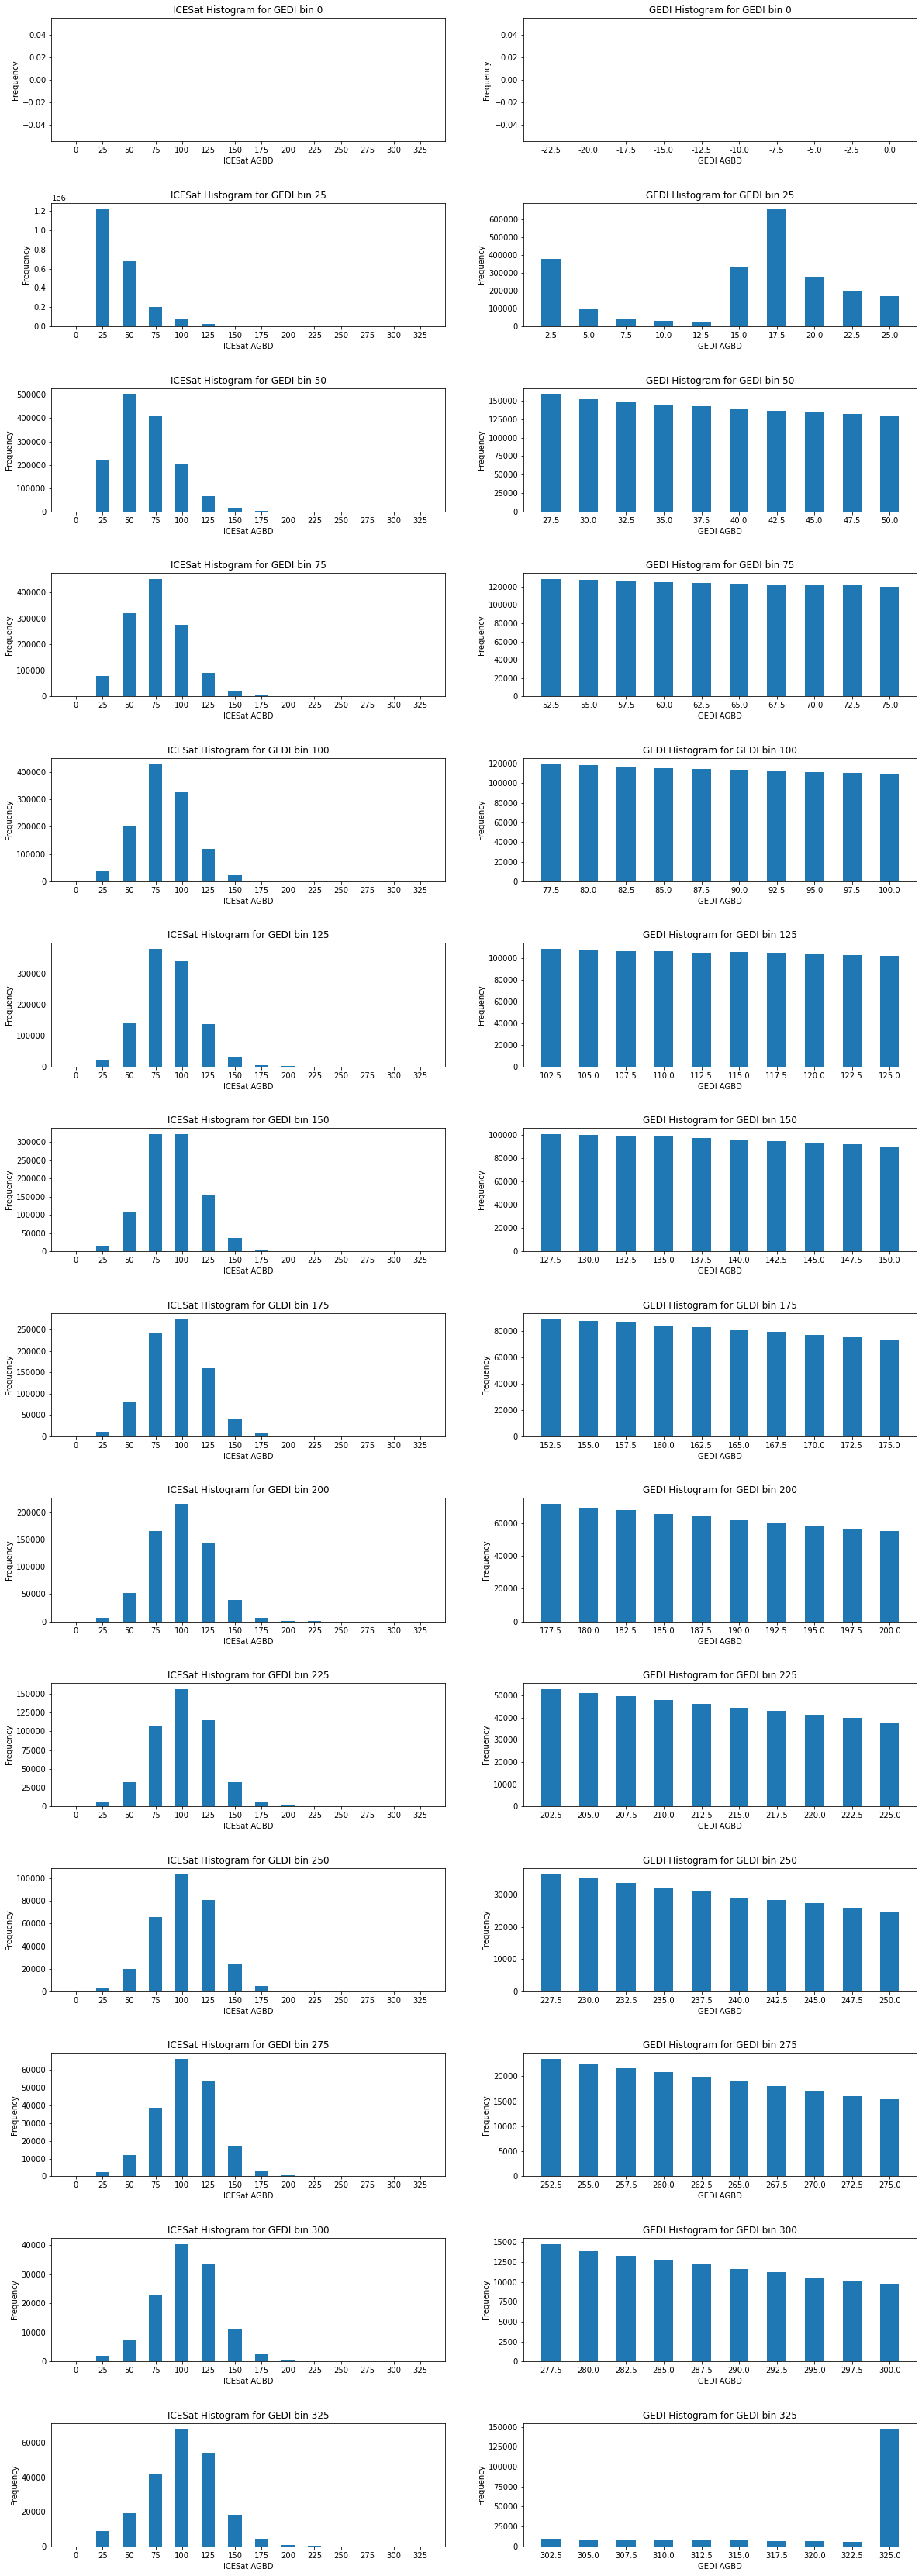

In [6]:
import numpy as np
import matplotlib.pyplot as plt

print(icesat_histograms.astype(int))

# Create subplots for histograms
fig, axs = plt.subplots(14, 2, figsize=(20, 60))

# Loop over each row in the arrays
for i in range(icesat_histograms.shape[0]):
    # Create a histogram for each row
    axs[i, 0].bar(height = icesat_histograms[i, :], x = np.arange(0,14), width=0.5)
    axs[i,0].set_title(f'ICESat Histogram for GEDI bin {i*25}')
    axs[i,0].set_xlabel('ICESat AGBD')
    axs[i,0].set_ylabel('Frequency')
    axs[i,0].set_xticks(np.arange(0,14))
    axs[i,0].set_xticklabels(np.arange(0,350,25))
    
    axs[i,1].bar(height = gedi_histograms[i, :], x = np.arange(0,10), width=0.5)
    axs[i,1].set_title(f'GEDI Histogram for GEDI bin {i*25}')
    axs[i,1].set_xlabel('GEDI AGBD')
    axs[i,1].set_ylabel('Frequency')
    axs[i,1].set_xticks(np.arange(0,10))
    axs[i,1].set_xticklabels(np.full(10,(i-1)*25)+ np.arange(2.5,27.5,2.5))

plt.subplots_adjust(hspace=0.5)
# Display the histograms
plt.show()

